In [5]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from PIL import Image

# Mount Google Drive if your data is stored there (uncomment if needed)
from google.colab import drive
drive.mount('/content/drive')

# Set paths - adjust to where you uploaded/extracted dataset in Colab


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Example: If uploaded to /content/ham10000/
DATA_DIR = '/content/drive/MyDrive/CSE465/dataset'  # change this as needed
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2') # Corrected directory name
METADATA_CSV = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')

In [7]:
# Example: listing files in first folder to verify
print(f"Number of images in part1: {len(os.listdir(IMG_DIR1))}")
print(f"Number of images in part2: {len(os.listdir(IMG_DIR2))}")
print(f"Metadata CSV Path: {METADATA_CSV}")

Number of images in part1: 5000
Number of images in part2: 5015
Metadata CSV Path: /content/drive/MyDrive/CSE465/dataset/HAM10000_metadata.csv


In [8]:
# 1) Load metadata CSV
df = pd.read_csv(METADATA_CSV)
print("Metadata head:")
print(df.head())

Metadata head:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [9]:
# 2) Check classes and distribution
print("\nClass distribution:")
print(df['dx'].value_counts())


Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [10]:
# Map class codes to full names if needed (optional)
class_names = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesions'
}


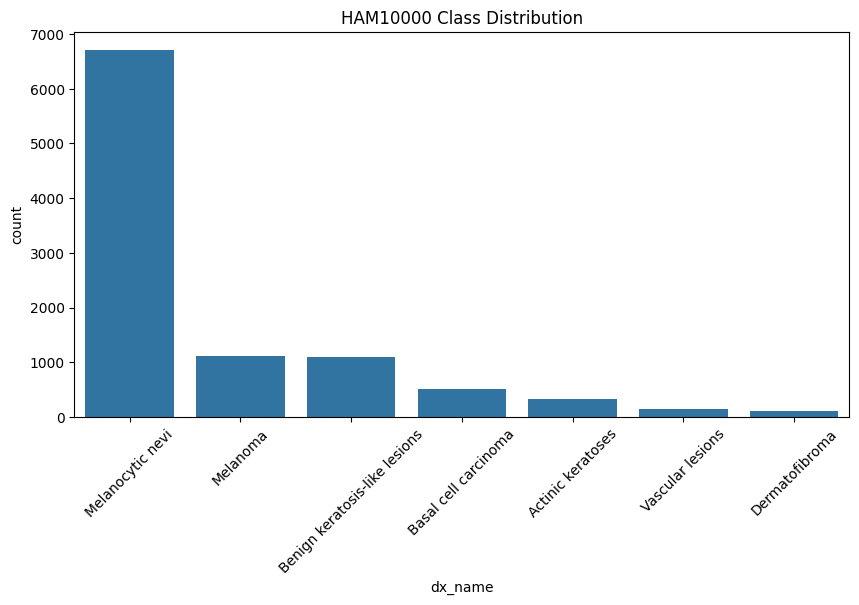

In [11]:
df['dx_name'] = df['dx'].map(class_names)

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dx_name', order=df['dx_name'].value_counts().index)
plt.xticks(rotation=45)
plt.title('HAM10000 Class Distribution')
plt.show()

In [12]:
# 3) Check for duplicates (image_id repeated)
dup_images = df['image_id'].duplicated().sum()
print(f"Number of duplicated image_ids: {dup_images}")

Number of duplicated image_ids: 0


In [13]:
# 4) Check lesion_id duplicates (same lesion multiple images)
lesion_counts = df['lesion_id'].value_counts()
print(f"Number of unique lesions: {len(lesion_counts)}")
print(f"Lesions with multiple images: {(lesion_counts > 1).sum()}")

Number of unique lesions: 7470
Lesions with multiple images: 1956


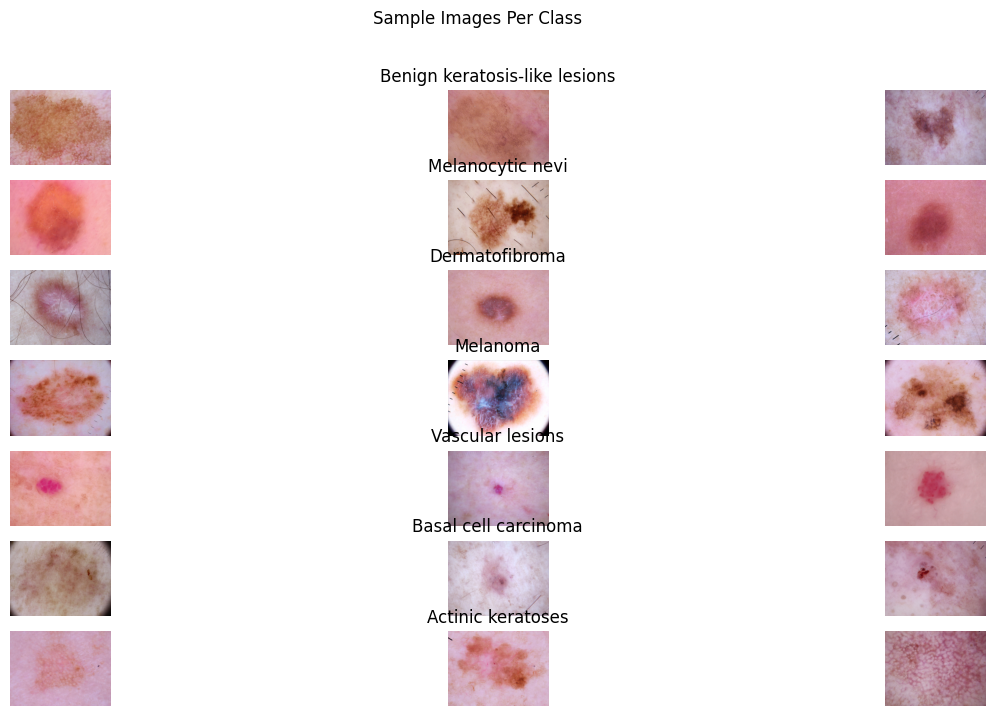

In [14]:
# 6) Visualize sample images per class
def plot_samples_per_class(df, img_dirs, samples_per_class=3):
    plt.figure(figsize=(16, 8))
    classes = df['dx'].unique()
    for i, cls in enumerate(classes):
        cls_df = df[df['dx'] == cls].sample(samples_per_class, random_state=42)
        for j, (_, row) in enumerate(cls_df.iterrows()):
            img_id = row['image_id']
            # Search image in both folders
            img_path1 = os.path.join(img_dirs[0], img_id + '.jpg')
            img_path2 = os.path.join(img_dirs[1], img_id + '.jpg')
            img_path = img_path1 if os.path.exists(img_path1) else img_path2

            img = Image.open(img_path)
            plt.subplot(len(classes), samples_per_class, i * samples_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == samples_per_class // 2:
                plt.title(class_names.get(cls, cls))
    plt.suptitle('Sample Images Per Class')
    plt.show()

plot_samples_per_class(df, [IMG_DIR1, IMG_DIR2])

In [15]:
# 7) Prepare GroupKFold splits by lesion_id (stratified by dx)
gkf = GroupKFold(n_splits=5)

df['fold'] = -1
X = df.index.values
y = df['dx'].values
groups = df['lesion_id'].values

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    df.loc[val_idx, 'fold'] = fold

print("\nFold distribution:")
print(df['fold'].value_counts())



Fold distribution:
fold
0    2003
2    2003
1    2003
3    2003
4    2003
Name: count, dtype: int64


In [16]:
# Save fold assignments for later validation and testing
df.to_csv(os.path.join(DATA_DIR, 'ham10000_metadata_folds.csv'), index=False)

print("Saved fold assignments to 'ham10000_metadata_folds.csv'")

Saved fold assignments to 'ham10000_metadata_folds.csv'


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np

In [18]:
# Paths
DATA_DIR = '/content/drive/MyDrive/CSE465/dataset'
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')
METADATA_CSV2 = os.path.join(DATA_DIR, 'ham10000_metadata_folds.csv')



In [19]:
# Load CSV with folds (generated in Phase 1)
df = pd.read_csv(METADATA_CSV2)

In [20]:
# Map classes to indices
class_names = sorted(df['dx'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print("Class to index mapping:", class_to_idx)

Class to index mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [21]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_name,fold
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0


In [22]:
# ---------------------------
# Image Transforms
# ---------------------------
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [23]:
# ---------------------------
# Dataset Class
# ---------------------------
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir1, img_dir2, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['image_id'] + '.jpg'

        img_path1 = os.path.join(self.img_dir1, img_filename)
        img_path2 = os.path.join(self.img_dir2, img_filename)

        if os.path.exists(img_path1):
            img_path = img_path1
        elif os.path.exists(img_path2):
            img_path = img_path2
        else:
            raise FileNotFoundError(f"Image {img_filename} not found in either folder.")

        image = Image.open(img_path).convert("RGB")
        label = class_to_idx[row['dx']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [24]:
# ---------------------------
# Create DataLoaders
# ---------------------------
def get_dataloaders(fold, batch_size=32, use_sampler=True):
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]

    train_dataset = HAM10000Dataset(train_df, IMG_DIR1, IMG_DIR2, transform=train_transforms)
    val_dataset = HAM10000Dataset(val_df, IMG_DIR1, IMG_DIR2, transform=val_transforms)

    if use_sampler:
        class_counts = train_df['dx'].value_counts().to_dict()
        class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
        sample_weights = [class_weights[row['dx']] for _, row in train_df.iterrows()]
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [25]:
# ---------------------------
# Example: Load fold 0
# ---------------------------
train_loader, val_loader = get_dataloaders(fold=0, batch_size=32)

# Check one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Batch labels:", labels)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([0, 2, 5, 6, 3, 6, 4, 4, 2, 4, 3, 0, 1, 1, 1, 2, 6, 5, 0, 3, 4, 4, 1, 2,
        4, 0, 0, 2, 5, 3, 0, 3])


# **Trainign Teacher**

In [26]:
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
import copy
import time


In [27]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣ Load pretrained EfficientNet-B4
num_classes = len(class_to_idx) # from Phase 2
model = timm.create_model('efficientnet_b4', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# 2️⃣ Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Cosine Annealing LR
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# 3️⃣ Training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

# 4️⃣ Train minimal teacher
teacher_model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

# 5️⃣ Save best weights
torch.save(teacher_model.state_dict(), "teacher_model_minimal.pth")
print("✅ Teacher model (minimal) saved as teacher_model_minimal.pth")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]


Epoch 1/10
------------------------------
train Loss: 1.3630 Acc: 0.5233
val Loss: 0.8732 Acc: 0.6780

Epoch 2/10
------------------------------
train Loss: 0.6786 Acc: 0.7488
val Loss: 0.7182 Acc: 0.7249

Epoch 3/10
------------------------------
train Loss: 0.4964 Acc: 0.8176
val Loss: 0.6420 Acc: 0.7459

Epoch 4/10
------------------------------
train Loss: 0.4356 Acc: 0.8380
val Loss: 0.6602 Acc: 0.7559

Epoch 5/10
------------------------------
train Loss: 0.3902 Acc: 0.8528
val Loss: 0.6003 Acc: 0.7748

Epoch 6/10
------------------------------
train Loss: 0.3422 Acc: 0.8702
val Loss: 0.5850 Acc: 0.7813

Epoch 7/10
------------------------------
train Loss: 0.3079 Acc: 0.8869
val Loss: 0.5878 Acc: 0.7818

Epoch 8/10
------------------------------
train Loss: 0.2913 Acc: 0.8912
val Loss: 0.5703 Acc: 0.7938

Epoch 9/10
------------------------------
train Loss: 0.2830 Acc: 0.8968
val Loss: 0.5843 Acc: 0.7948

Epoch 10/10
------------------------------
train Loss: 0.2932 Acc: 0.893